In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pylab

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os

from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from statsmodels.stats.diagnostic import lilliefors
from scipy.spatial.distance import cdist
from scipy.stats import shapiro, kstest

plt.style.use('ggplot')

In [50]:
def encode_categorical_data(df: pd.DataFrame) -> pd.DataFrame:
    # turn each row as key-value pairs
    #df_dict = df.to_dict(orient='records')
    #vectorizer = DictVectorizer(sparse=False)
    #df_encoded = vectorizer.fit_transform(df_dict)
    
    return pd.get_dummies(df, prefix_sep='_', drop_first=False)

def feature_distributions(df: pd.DataFrame, color_index=0):
    '''
    Graphs the distribution for each column.
    
    Args:
        df(dataframe): The dataframe with the data.
    '''
    # pick more colors depending on number of clusters
    #colors = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
    
    sns.set(style="ticks", palette="bright")
    f, axes = plt.subplots(ncols=len(df.columns))
    f.set_size_inches(15, 5)
    sns.despine(left=True)
    
    for ax, col in zip(axes, df.columns):
        sns.distplot(df[col], ax=ax)#, color=colors[color_index])
        plt.setp(axes, yticks=[])
        # plt.tight_layout()
    
    #plt.savefig("../../figures/cluster" + str(color_index) + ".png") 
    plt.show()

def standardize_data(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Standardizes the data.
    
    Args:
        df(dataframe): The data.
    
    Returns:
        dataframe: The standardized data.
    '''
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df)
    return pd.DataFrame(scaled_df, columns=df.columns)

def center_data(df: pd.DataFrame, cols: list):
    '''
    Perform log transformation on the specified columns in the dataframe.
    
    Args:
        df (dataframe): The dataframe to transform.
        cols (list): The columns to transform.
    '''
    for col in df.columns.values:
        if col in cols:
            min_val = df[col].min()
            df[col] = np.log(abs(df[col].min()) + 1 + df[col])
            
def pca_ratios(df, ax=None):
    '''
    Obtains the feature variance.
    
    Args:
        df(dataframe): The dataframe with the data.
    '''
    if ax is None:
        fig, ax = plt.subplots()
    scaler = StandardScaler()
    # Create a PCA instance: pca
    pca = PCA()

    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler, pca)

    # Fit the pipeline to df.values
    pipeline.fit(df.values)

    # Plot the explained variances
    features = range(pca.n_components_)
    ax.bar(features, pca.explained_variance_ratio_)
    ax.set_xlabel('PCA feature')
    ax.set_ylabel('variance ratio')
    plt.xticks(features, rotation=345)
    #plt.savefig("../../figures/pca_variance.png") 
    plt.show()
    
    
def pca_cumulative(data, ax=None):
    '''
    Check the cumulative variance plotted against the features
    
    Args:
        data(dataframe): The data to plot
    '''
    if ax is None:
        fig, ax = plt.subplots()
    
    pca = PCA()
    pca.fit_transform(data)

    ax.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
    plt.xticks()
    ax.set_ylabel('variance ratio')
    ax.set_xlabel('PCA feature')
    plt.tight_layout()
    #plt.savefig('../../figures/pca_variance_ratio.png')

    ax.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
    plt.xticks()
    ax.set_ylabel('cumulative sum of variances')
    ax.set_xlabel('PCA feature')
    plt.tight_layout()
    #plt.savefig('../../figures/pca_variance_ratio_cumsum.png')

    
def feature_reduction(df: pd.DataFrame, num_components: int) -> pd.DataFrame:
    '''
    Performs feature reduction.
    
    Args:
        scaled(dataframe): The restandardized data.
        num_components(int): The number of components to use for PCA.
        
    Returns:
        dataframe: PCA features
    '''
    pca = PCA(n_components=num_components)
    pca.fit(df)
    pca_features = pca.transform(df)
    return pd.DataFrame(pca_features)

def elbow_method(df: pd.DataFrame):
    '''
    Determine the optimal number of clusters using the elbow method.
    
    Args:
        df (dataframe): The dataframe with the data
    '''
    plt.plot()
    colors = ['b', 'g', 'r']
    markers = ['o', 'v', 's']

    # determine k
    distortions = []
    K = range(1,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    #plt.savefig("../../figures/elbow.png")
    plt.show()
    
def data_cleaning(data: pd.DataFrame, feature_cols: list):
    # Drop unnecessary features
    all_features = data[feature_cols].copy()
    
    # Split data into categories
    num_cols = list(data.select_dtypes("int64").columns) + list(data.select_dtypes("float64").columns)
    cat_cols = list(data.select_dtypes("object").columns)
            
    # Fill in null values
    for col in all_features.columns:
        if all_features[col].dtype == 'float64':
            all_features[col].fillna(all_features[col].median(), inplace=True)
        else:
            all_features[col].fillna("unknown", inplace=True)
            
    # 1a. Center numerical data
    num_df = all_features[num_cols].copy()
    center_data(num_df, num_cols)

    # 1b. Encode categorical data
    cat_df = encode_categorical_data(all_features[cat_cols].copy())

     # 2. Normalize data
    scaled = pd.DataFrame(Normalizer().fit_transform(num_df.values), columns=num_df.columns)
    
    # 3. Decorrelate the data
    decorrelated = pd.DataFrame(StandardScaler().fit_transform(scaled.values), columns=num_df.columns)

    # 4. Restandardize
    restandardized = standardize_data(decorrelated)
    
    # 1c. Merge the data
    new_data = pd.concat([cat_df, restandardized], axis=1)

    return (num_cols, cat_cols, new_data, all_features)
    

In [48]:
def kmeans_clusters(df: pd.DataFrame, num_clusters: int):
    '''
    Performs KMeans clustering on the data.
    
    Args:
        df(dataframe): The dataframe with the data.
        num_clusters(int): The number of clusters to cluster by.
        
    Returns:
        dataframe: Dataframe with the number of patients per cluster.
    '''
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=200, random_state=42)
    kmeans.fit(df.values)
    labels = kmeans.predict(df.values)
  
    xs = df.values[:,0]
    ys = df.values[:,1]

    # Assign the cluster centers: centroids
    centroids = kmeans.cluster_centers_

    # Assign the columns of centroids: centroids_x, centroids_y
    centroids_x = centroids[:,0]
    centroids_y = centroids[:,1]

    # pick colors
    #customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
    
    components = pd.DataFrame({'First Principal Component': xs, 'Second Principal Component': ys, 'label': labels})
    facet = sns.lmplot(data=components, x='First Principal Component', y='Second Principal Component', hue='label', fit_reg=False, legend=False)

    #add a legend
    leg = facet.ax.legend(loc="upper left", bbox_to_anchor=(1,1), title="Cluster")
    #pylab.legend(loc='best')
    
    # plot centroids
    plt.scatter(centroids_x, centroids_y, marker='*', s=50, c="black")
    #plt.savefig("../../figures/all_clusters.png")
    plt.show()
    
    return labels

def count_clusters(labels):
    '''
    Count the clusters per label.
    
    Args:
        labels(array): Array of labels
    
    Returns:
        dataframe: Dataframe with number of elements per cluster
    '''
    values = np.array(labels)
    unique, counts = np.unique(values, return_counts=True)

    results = pd.DataFrame.from_records(np.array(list(zip(unique, counts))))
    results.columns = ["Cluster", "Number of Datapoints"]
    results.set_index("Cluster", inplace=True)
    return results

def cluster(decorrelated_data, original_data, cluster_counts):
    # Set number of clusters here
    all_results = dict()

    for num_clusters in cluster_counts:
         # Initialize final dataframe
        results = original_data.copy()
        
        clusters = kmeans_clusters(decorrelated_data, num_clusters)
        results["cluster"] = clusters
        
        print(count_clusters(results["cluster"]))
        all_results[num_clusters] = results
    
    return all_results

def cluster_profile_analysis(all_results, num_cols, cat_cols, num_clusters):
    # Create num_clusters dataframes, where each one contains data from a specific cluster
    for results in all_results.values():
        cluster_data = list()
        for val in range(num_clusters):
            cluster_data.append(results.loc[results["cluster"] == val])

        # Analyze numerical data
        #color_index = 0
        for cluster in cluster_data:
            feature_distributions(cluster[num_cols], color_index)
            #color_index += 1
            
        # Numerical profiles: mean, median
        print(results.groupby('cluster').mean())
        print(results.groupby('cluster').median())
        
        # Analyze categorical data
        for col in cat_cols:
            g = sns.catplot(col, col="cluster", data=results, kind="count")
            g.set_xticklabels(rotation=40)
            #g.savefig("../../figures/" + col + ".png") 

# Steps:

1. Centering
2. Standardization
3. Decorrelation
4. ReStandardization
5. Feature Reduction
6. Finding the optimal number of clusters
7. Deriving personas from clusters

In [38]:
data = pd.read_csv("../../data/cleaned/merged data - clustering.csv", thousands=',')
data["YEAR"] = data["YEAR"].astype("str")
feature_cols = data.columns.values

In [39]:
numerical_features, categorical_features, df, feature_data = data_cleaning(data, feature_cols)

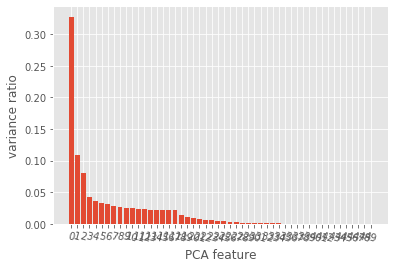

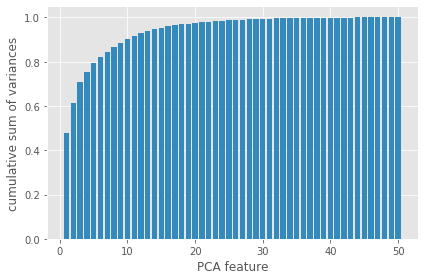

In [40]:
# Get PCA variance
pca_ratios(df)
pca_cumulative(df)

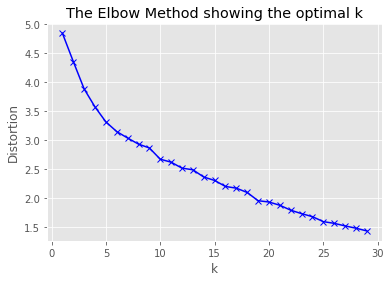

In [41]:
# 5. Feature reduction
num_features = 17
reduced_data = feature_reduction(df.copy(), num_features)

elbow_method(reduced_data)

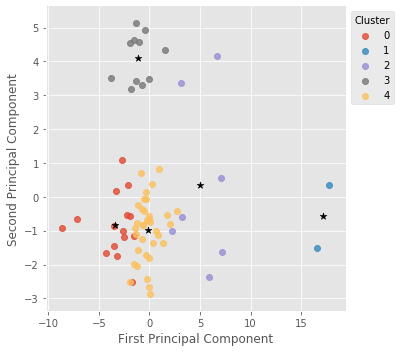

Number of Datapoints
Cluster                      
0                          15
1                           2
2                           7
3                          11
4                          35


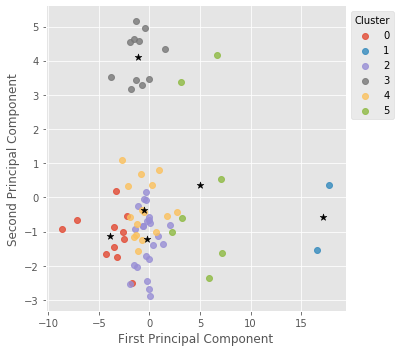

Number of Datapoints
Cluster                      
0                          11
1                           2
2                          23
3                          11
4                          16
5                           7


In [42]:
cluster_counts = [5, 6]
results = cluster(reduced_data, feature_data, cluster_counts)

In [95]:
analyzed_clusters = results[5]
cols = analyzed_clusters.columns.tolist()
cols = cols[-1:] + cols[:-1]
analyzed_clusters = analyzed_clusters[cols]

analysis_groups = analyzed_clusters.groupby("cluster")

In [98]:
for cluster in range(5):
    group = analysis_groups.get_group(cluster)
    print("Cluster: {}".format(cluster))
    display(group.describe(include="all"))
    print()

Cluster: 0


,cluster,YEAR,COUNTY,OPERATIONS WITH TAPS,OPERATIONS WITH SALES,NUMBER OF TAPS,SALES,PRODUCTION,TAVG,FZF9,...,CDSD,PRCP,FZF7,TMAX,FZF8,DT32,DT00,CLDD,FZF3,FZF1
count,15.0,15,15,15.000000,15.000000,1.500000e+01,1.500000e+01,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
unique,NaN,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2017,FRANKLIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,9,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.0,NaN,NaN,138.000000,131.466667,5.954657e+05,5.106267e+06,180913.800000,54.987619,7.338095,...,378.800000,45.730333,21.600000,35.881429,15.833333,158.766667,21.223810,378.800000,18.090476,25.761905
std,0.0,NaN,NaN,59.835489,58.567259,5.173188e+05,5.402794e+06,191180.114517,3.835728,7.377595,...,146.528617,5.129621,2.564873,5.539102,4.270608,14.822602,10.182084,146.528617,1.374080,1.757878
min,0.0,NaN,NaN,20.000000,20.000000,2.192490e+05,1.936000e+06,52241.000000,43.950000,-10.000000,...,163.000000,35.560000,15.000000,30.300000,4.000000,127.000000,5.000000,163.000000,15.000000,21.000000
25%,0.0,NaN,NaN,105.500000,101.500000,3.038770e+05,2.301500e+06,80821.000000,53.625000,3.000000,...,324.250000,43.340000,21.250000,33.500000,13.750000,157.000000,15.750000,324.250000,17.250000,24.750000
50%,0.0,NaN,NaN,137.000000,123.000000,4.131240e+05,3.469000e+06,128323.000000,55.500000,9.500000,...,360.000000,47.630000,22.000000,34.500000,17.000000,160.000000,20.500000,360.000000,18.500000,26.000000
75%,0.0,NaN,NaN,163.000000,144.000000,6.181765e+05,4.586500e+06,177872.500000,57.600000,12.035714,...,440.500000,49.765000,23.000000,35.775000,18.250000,167.000000,28.500000,440.500000,19.000000,26.964286



Cluster: 1


,cluster,YEAR,COUNTY,OPERATIONS WITH TAPS,OPERATIONS WITH SALES,NUMBER OF TAPS,SALES,PRODUCTION,TAVG,FZF9,...,CDSD,PRCP,FZF7,TMAX,FZF8,DT32,DT00,CLDD,FZF3,FZF1
count,2.0,2,2,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000
unique,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2012,GRAND ISLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.0,NaN,NaN,3.500000,3.500000,1104.000000,10500.000000,216.000000,57.600000,9.000000,...,683.000000,35.775000,15.500000,40.050000,15.500000,135.500000,5.50000,683.000000,14.000000,25.000000
std,0.0,NaN,NaN,0.707107,0.707107,560.028571,7778.174593,115.965512,1.979899,2.828427,...,172.534055,4.164859,6.363961,1.202082,6.363961,0.707107,2.12132,172.534055,4.242641,2.828427
min,1.0,NaN,NaN,3.000000,3.000000,708.000000,5000.000000,134.000000,56.200000,7.000000,...,561.000000,32.830000,11.000000,39.200000,11.000000,135.000000,4.00000,561.000000,11.000000,23.000000
25%,1.0,NaN,NaN,3.250000,3.250000,906.000000,7750.000000,175.000000,56.900000,8.000000,...,622.000000,34.302500,13.250000,39.625000,13.250000,135.250000,4.75000,622.000000,12.500000,24.000000
50%,1.0,NaN,NaN,3.500000,3.500000,1104.000000,10500.000000,216.000000,57.600000,9.000000,...,683.000000,35.775000,15.500000,40.050000,15.500000,135.500000,5.50000,683.000000,14.000000,25.000000
75%,1.0,NaN,NaN,3.750000,3.750000,1302.000000,13250.000000,257.000000,58.300000,10.000000,...,744.000000,37.247500,17.750000,40.475000,17.750000,135.750000,6.25000,744.000000,15.500000,26.000000



Cluster: 2


,cluster,YEAR,COUNTY,OPERATIONS WITH TAPS,OPERATIONS WITH SALES,NUMBER OF TAPS,SALES,PRODUCTION,TAVG,FZF9,...,CDSD,PRCP,FZF7,TMAX,FZF8,DT32,DT00,CLDD,FZF3,FZF1
count,7.0,7,7,7.000000,7.000000,7.000000,7.000000e+00,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
unique,NaN,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2002,ESSEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.0,NaN,NaN,12.142857,91.857143,16017.285714,1.820429e+06,16335.142857,44.387202,13.497253,...,336.222135,39.509464,22.362637,49.606305,15.993132,140.472527,20.590110,215.575092,17.177002,25.706338
std,0.0,NaN,NaN,7.197883,32.126980,13181.375178,7.185105e+05,22303.337711,5.470547,1.587225,...,169.634695,5.662205,2.299114,7.484313,1.797080,35.511268,15.929868,125.452408,1.687593,2.175680
min,2.0,NaN,NaN,3.000000,19.000000,3801.000000,1.910000e+05,918.000000,38.850000,11.250000,...,148.269231,28.960000,18.000000,33.250000,13.000000,91.000000,4.000000,74.000000,14.142857,21.846154
25%,2.0,NaN,NaN,6.000000,104.000000,7340.000000,2.092000e+06,1481.500000,40.221875,12.500000,...,216.500000,37.370000,21.519231,50.167067,15.000000,113.000000,9.200000,124.346154,16.423077,24.656250
50%,2.0,NaN,NaN,14.000000,104.000000,10600.000000,2.092000e+06,5745.000000,45.100000,13.730769,...,267.000000,41.930000,23.500000,50.800000,17.000000,154.000000,15.000000,179.000000,17.750000,26.000000
75%,2.0,NaN,NaN,17.500000,104.000000,21545.000000,2.092000e+06,27958.750000,45.733333,14.250000,...,452.142857,42.548125,24.000000,54.130000,17.187500,165.653846,30.615385,300.166667,18.250000,27.392857



Cluster: 3


,cluster,YEAR,COUNTY,OPERATIONS WITH TAPS,OPERATIONS WITH SALES,NUMBER OF TAPS,SALES,PRODUCTION,TAVG,FZF9,...,CDSD,PRCP,FZF7,TMAX,FZF8,DT32,DT00,CLDD,FZF3,FZF1
count,11.0,11,11,11.000000,11.0,11.000000,11.0,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
unique,NaN,1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2002,CALEDONIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.0,NaN,NaN,143.000000,104.0,203526.272727,2092000.0,45840.818182,44.073987,11.376521,...,388.057576,46.445784,21.755995,54.310332,17.475667,94.833333,10.027273,88.818182,18.584616,147.922393
std,0.0,NaN,NaN,57.569089,0.0,140447.882690,0.0,31695.913894,1.809520,2.771472,...,133.519461,5.182893,1.581292,2.550888,3.658450,6.467869,3.177764,12.100150,0.933368,125.362122
min,3.0,NaN,NaN,64.000000,104.0,55381.000000,2092000.0,12085.000000,40.080000,5.000000,...,199.000000,40.000909,18.727273,48.860000,6.666667,87.000000,4.600000,72.000000,17.000000,22.800000
25%,3.0,NaN,NaN,96.500000,104.0,127531.000000,2092000.0,27272.000000,43.150000,10.415020,...,260.250000,43.207364,21.000000,52.796104,17.856522,91.500000,8.200000,81.000000,17.893478,25.809524
50%,3.0,NaN,NaN,135.000000,104.0,163438.000000,2092000.0,37799.000000,44.382609,11.000000,...,456.500000,45.951364,21.727273,54.812500,18.500000,94.000000,9.500000,87.000000,18.681818,140.000000
75%,3.0,NaN,NaN,190.500000,104.0,241664.500000,2092000.0,51914.500000,45.378030,13.000000,...,479.666667,48.690000,22.557971,55.903261,18.882155,97.250000,12.150000,95.750000,19.240741,280.000000



Cluster: 4


,cluster,YEAR,COUNTY,OPERATIONS WITH TAPS,OPERATIONS WITH SALES,NUMBER OF TAPS,SALES,PRODUCTION,TAVG,FZF9,...,CDSD,PRCP,FZF7,TMAX,FZF8,DT32,DT00,CLDD,FZF3,FZF1
count,35.0,35,35,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000,35.000000,...,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
unique,NaN,5,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,1997,WINDHAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,12,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.0,NaN,NaN,107.171429,101.028571,183650.514286,1.883657e+06,45006.085714,46.993530,10.935027,...,293.007830,45.218619,22.246429,48.452679,15.584478,171.230220,21.152143,282.121173,18.408104,25.788462
std,0.0,NaN,NaN,40.645878,19.823465,85570.253951,4.352251e+05,16832.233225,6.673203,5.946739,...,125.794442,10.433188,1.827206,8.435664,4.854395,17.258456,11.086883,126.334832,1.181132,1.832642
min,4.0,NaN,NaN,31.000000,31.000000,43754.000000,6.640000e+05,10426.000000,36.900000,-5.000000,...,74.500000,30.285000,18.000000,32.950000,-2.000000,137.000000,4.000000,74.500000,15.500000,22.000000
25%,4.0,NaN,NaN,87.000000,104.000000,122874.000000,2.028500e+06,36026.500000,42.675000,9.250000,...,220.750000,39.510000,21.500000,38.246875,14.000000,160.307692,13.500000,198.000000,18.000000,24.375000
50%,4.0,NaN,NaN,104.000000,104.000000,171675.000000,2.092000e+06,48802.500000,44.600000,13.000000,...,285.500000,43.720000,23.000000,52.800000,18.000000,172.000000,19.125000,282.000000,18.500000,26.000000
75%,4.0,NaN,NaN,126.500000,104.000000,220859.000000,2.092000e+06,48972.500000,54.225000,15.000000,...,373.500000,47.565000,23.250000,55.025000,18.843750,181.500000,27.000000,353.500000,19.076923,27.000000
